#**Deep Learning Homework 3: Convolutional Neural Networks**
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. We will use the CIFAR-10 dataset. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters on the learning performances.

# Requirements
Let's start importing the libraries we will need and setting a couple of environmental variables.

**Disclaimer**: the notebook has been tested in Colab with Python `3.9.16`. Some parts *may* not work as expected using different packages and Python versions.

In [1]:
print("You are using:")
!python3 --version


You are using:
Python 3.9.16


In [ ]:
# They've just released torch 2.0, but we will use the more stable torch=1.13 along with other supporting libriaries
!pip3 install pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

In [4]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from torchinfo import summary
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 525.105.17, 15360 MiB, 3 MiB, 15098 MiB


# Exercise 3.1: Simple CNN

## Data Loading and Preprocessing [TO COMPLETE]


We will use the `CIFAR-10` dataset.The dataset consists of $60.000$ images in $10$ classes, with $6.000$ images per class. There are $50.000$ training images and $10.000$ test images. Each sample is a $32\times32$ pixels color image (thus with an extra $\times3$ dimensions for the colors channels), associated with a label from one of the classes:

```python
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
```

We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.

**[TO COMPLETE]**

In the standard dataset, each pixel intensity is represented by a `uint8` (byte) from $0$ to $255$. As a preprocessing step, we will rescale these values in the range $[0,1]$. You should write a simple so-called MinMaxScaler which takes as input a PIL Image (a specific format for images in Python) and rescales it, after making the appropriate type and shape transformations.

`%STARTCODE`

In [5]:
def MinMaxScaler(img):#[TO COMPLETE]
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  # TO COMPLETE: Transform the array to Tensor for PyTorch
  tensor_img = torch.Tensor(img_as_array)
  # TO COMPLETE: image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  permuted_img = tensor_img.permute((2,0,1))
  # TO COMPLETE: Rescale image pixels form [0,255] to [0,1]
  normalized_img = permuted_img/255
  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(MinMaxScaler)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(MinMaxScaler)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


`%ENDCODE`

In [6]:
# Let's check the classes and dataset shapes:
classes = dataset.classes
print(f"{classes=}")
print(f"Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {test_data.data.shape}")

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [7]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Lambda()

In [8]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

We split the dataset into training/validation sets:

In [9]:
val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 45000 
Validation samples = 5000 
Test samples = 10000


Let's see how normalized sample looks like...

In [10]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.7373, 0.7216, 0.7255,  ..., 0.7922, 0.7922, 0.7882],
         [0.7216, 0.7059, 0.7137,  ..., 0.7765, 0.7725, 0.7725],
         [0.7373, 0.7255, 0.7216,  ..., 0.7569, 0.7529, 0.7490],
         ...,
         [0.7608, 0.7608, 0.7647,  ..., 0.7647, 0.7765, 0.7686],
         [0.8039, 0.8000, 0.8039,  ..., 0.8157, 0.8157, 0.8000],
         [0.8235, 0.8157, 0.8157,  ..., 0.7922, 0.8000, 0.7804]],

        [[0.6902, 0.6784, 0.6824,  ..., 0.7490, 0.7490, 0.7451],
         [0.6784, 0.6627, 0.6706,  ..., 0.7333, 0.7294, 0.7294],
         [0.6941, 0.6824, 0.6784,  ..., 0.7137, 0.7098, 0.7059],
         ...,
         [0.7137, 0.7098, 0.7137,  ..., 0.7137, 0.7255, 0.7176],
         [0.7569, 0.7569, 0.7608,  ..., 0.7725, 0.7725, 0.7569],
         [0.7804, 0.7725, 0.7725,  ..., 0.7490, 0.7569, 0.7373]],

        [[0.6745, 0.6627, 0.6667,  ..., 0.7333, 0.7333, 0.7294],
         [0.6588, 0.6471, 0.6549,  ..., 0.7176, 0.7137, 0.7137],
         [0.6784, 0.6667, 0.6627,  ..., 0.6980, 0.6941, 0

... it's better to see it as images!

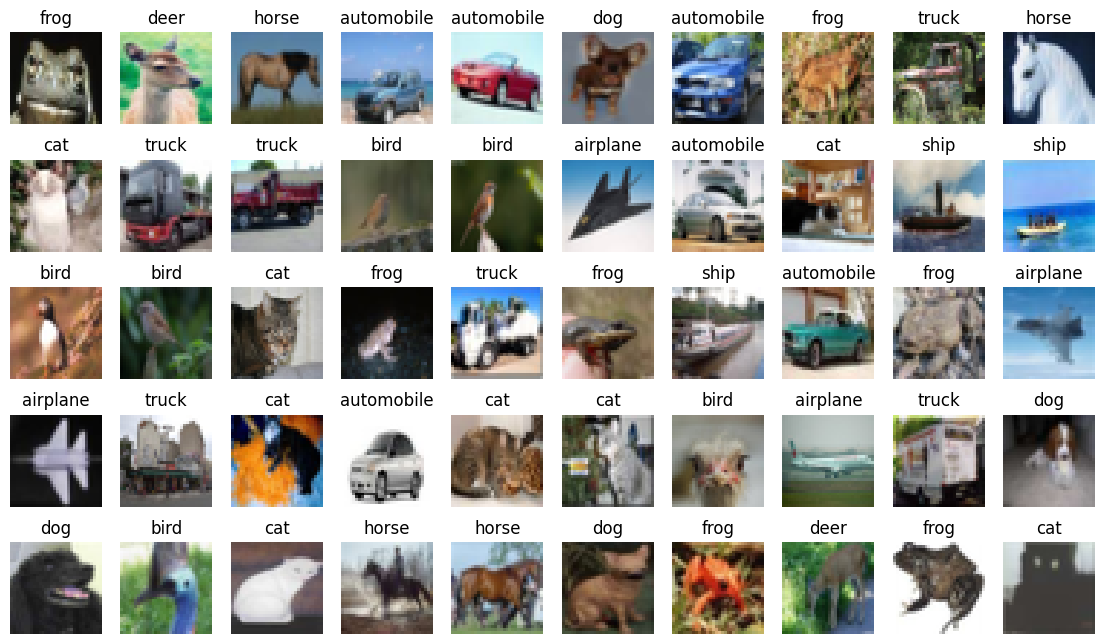

In [11]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Explain in the cell below when using Gradient Descent, why it is usually a good idea to ensure that all the features have a similar scale.

`%STARTEXT`

Answer: **[TO COMPLETE]**

In Gradient Descent, the weights are updated by the magnitude of the input and the learning rate. By having features with similar scale, the steps taken would be more evenly distributed among the given features. On the other hand, if we had 2 features with very different scales, then Gradient Descent would be greatly influerenced by the feature with the larger scale compared to the other feature (smaller scale), so that the steps are big for the first feature and small for the second. This may lead to a slower process to find the minimum value as the first feature may hop over the true minimum over and over and the second feature would take long to move towards the minimum. Therefore, the gradient will be more stable by making more consistent steps towards the minimum at each iteration.

`%ENDTEXT`

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [12]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

##Model Definition and Training

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLU activation function
* a Max Pooling layer (2D) of size 2x2.
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class). We do not need to normalize or transform further the outputs, as the `CrossEntropyLoss` takes care of that. Another equivalent approach would be to add a `LogSoftmax` final layer that returns log-probabilities and then use the `NegativeLogLikelihoodLoss`., and with the _softmax_ activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as `input_shape` attribute's value in the first layer report also the third dimension that represents the channel.

In [13]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        #Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))

      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))

    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) #if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) #no need to use softmax because of the loss function

In [14]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

Note that the number of parameters mostly depends on the output layers, indeed the parameter sharing techinique used by the 2D convolutional layers allows to significantly reduce the number of learnable weights.
Now we can train the model.

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [17]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 40.41%, Loss: 1.70188940 ---------------- Val_Acc: 48.22%, Val_Loss: 1.51181579
epoch: 2 -> Accuracy: 51.78%, Loss: 1.39579487 ---------------- Val_Acc: 52.28%, Val_Loss: 1.37461364
epoch: 3 -> Accuracy: 55.88%, Loss: 1.28210390 ---------------- Val_Acc: 54.44%, Val_Loss: 1.30316424
epoch: 4 -> Accuracy: 58.37%, Loss: 1.20809150 ---------------- Val_Acc: 56.84%, Val_Loss: 1.23920071
epoch: 5 -> Accuracy: 60.31%, Loss: 1.15325630 ---------------- Val_Acc: 56.30%, Val_Loss: 1.23728216
epoch: 6 -> Accuracy: 61.80%, Loss: 1.11143303 ---------------- Val_Acc: 58.26%, Val_Loss: 1.18768966
epoch: 7 -> Accuracy: 62.86%, Loss: 1.07727194 ---------------- Val_Acc: 59.16%, Val_Loss: 1.16222346
epoch: 8 -> Accuracy: 63.98%, Loss: 1.05205059 ---------------- Val_Acc: 60.10%, Val_Loss: 1.15751100
epoch: 9 -> Accuracy: 64.74%, Loss: 1.02739871 ---------------- Val_Acc: 60.70%, Val_Loss: 1.14118278
epoch: 10 -> Accuracy: 65.75%, Loss: 1.00159335 ---------------- Val_Acc: 59.84%, 

In [18]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(num_epochs), acc_tr, label='acc_training')
    plt.plot(range(num_epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(num_epochs), loss_tr, label='loss_training')
    plt.plot(range(num_epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

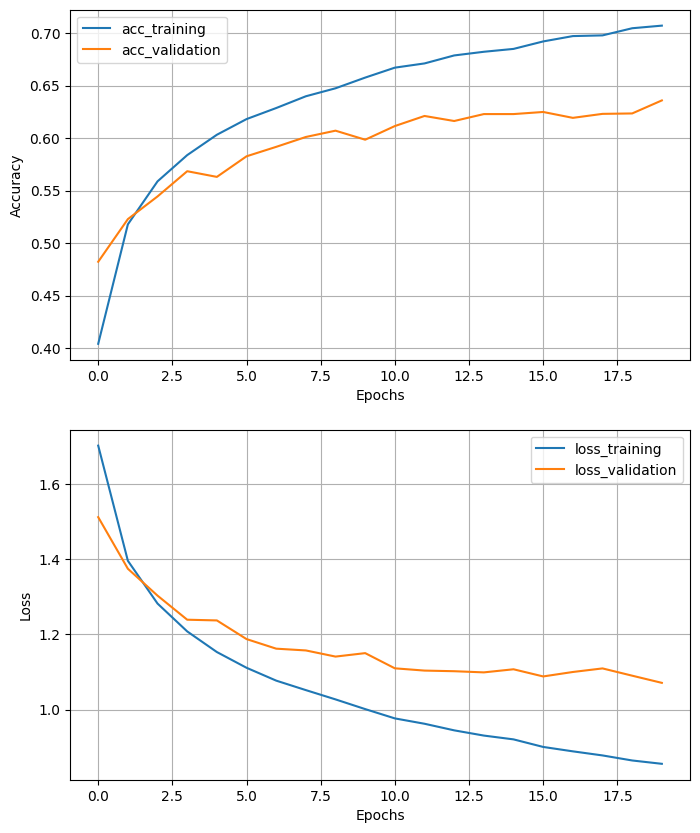

In [19]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

Finally, we test the model:

In [20]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [21]:
test(model)

Test Loss: 1.05096650 ---------- Test Accuracy: 63.8400%


Here we see that the test accuracy of our simple CNN is about 64%.

## Visualize filters
Let's now visualize the filters emerged in the first convolutional layer.

In [22]:
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


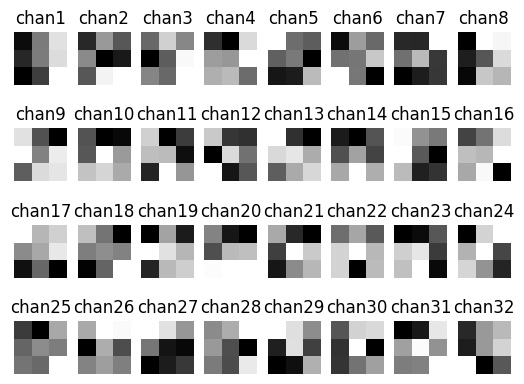

In [23]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect various corners and edges.

## Parameters of a CNN [TO COMPLETE]

Explain in the cell below:

1. How are the number of parameters for Conv2D layers are determined? Perform the calculations to calculate the parameters of the Conv2D layer.

`%STARTEXT`

Answer1 : **[TO COMPLETE]**

The number of parameters for Conv2D layers are determined by the number of filters, the size of these filters, the number of input channels and the bias, it is (number of input channels $*$ size of filter (i.e. width $\times$ height) $+$ 1 bias term) $*$ no of filters. In our model, we have 32 filters of size 3 times 3 each and 3 input channels, so our number of parameters is $(3 * 3 * 3 + 1) * 32 = 896$.

`%ENDTEXT`

# Exercise 3.2: Deep CNN


Let's consider a deeper model, more precisly in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the _softmax_ activation function


In [24]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         2,064
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 13,210
Trainable params: 13,210
Non-trainable params: 0
Total mult-adds (M): 372.77
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.05
Estimated Total S

In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [26]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 34.73%, Loss: 1.84366667 ---------------- Val_Acc: 41.68%, Val_Loss: 1.64541078
epoch: 2 -> Accuracy: 45.66%, Loss: 1.53723896 ---------------- Val_Acc: 47.20%, Val_Loss: 1.48064697
epoch: 3 -> Accuracy: 50.21%, Loss: 1.40840757 ---------------- Val_Acc: 50.70%, Val_Loss: 1.39935100
epoch: 4 -> Accuracy: 52.50%, Loss: 1.34061289 ---------------- Val_Acc: 52.18%, Val_Loss: 1.34354579
epoch: 5 -> Accuracy: 54.57%, Loss: 1.29002011 ---------------- Val_Acc: 53.94%, Val_Loss: 1.30436075
epoch: 6 -> Accuracy: 55.93%, Loss: 1.25760853 ---------------- Val_Acc: 55.50%, Val_Loss: 1.27804077
epoch: 7 -> Accuracy: 56.92%, Loss: 1.22989607 ---------------- Val_Acc: 55.28%, Val_Loss: 1.26501644
epoch: 8 -> Accuracy: 57.74%, Loss: 1.20287597 ---------------- Val_Acc: 56.42%, Val_Loss: 1.23324311
epoch: 9 -> Accuracy: 58.99%, Loss: 1.17387545 ---------------- Val_Acc: 57.42%, Val_Loss: 1.21870875
epoch: 10 -> Accuracy: 59.46%, Loss: 1.15993857 ---------------- Val_Acc: 56.20%, 

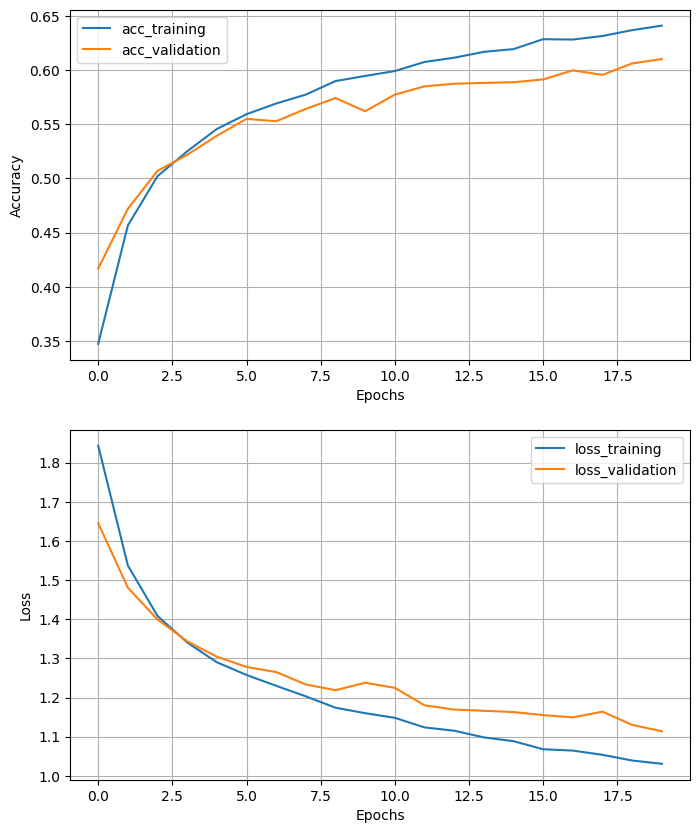

In [27]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [28]:
test(deep_model)

Test Loss: 1.07260787 ---------- Test Accuracy: 62.5100%


Whoa! By developing the deep CNN we dropped the accuracy fom ~64% to ~62%. It seems like we need to develop a better CNN model.

# Exercise 3.3: A better CNN [TO COMPLETE]

Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model.

**[TO COMPLETE]**: Your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. At least one of the models you try should have an improvement in the test set results (generalization) over the result of the model used in the previous exercise.
In the cell below report only the code of the **best model** that you can find. In addtion, print out its result on the test set, and plot the accuracy and the loss trends in the notebook you return.
Moreover, for each setup you test, analyze and discuss the obtained results briefly in the last cells at the bottom.

Hint: Each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same.
Example parameters to try to change (we suggest to test at least one re-parametrization for each of these categories):

*    number of layers or neurons or filters dimension
*   activation functions
*   epochs
*   batch sizes
*   max-pooling on/off on certain layers, or pool size

`%STARTCODE`

In [44]:
# TO COMPLETE

batch_size = 128
conv_filters = [128, 64]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.tanh, F.tanh]
num_epochs = 20

lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [128, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [128, 128, 32, 32]        3,584
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [128, 128, 16, 16]        --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [128, 64, 16, 16]         32,832
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [128, 64, 8, 8]           --
├─Linear: 1-5                            [128, 10]                 40,970
Total params: 77,386
Trainable params: 77,386
Non-trainable params: 0
Total mult-adds (G): 1.55
Input size (MB): 1.57
Forward/backward pass size (MB): 151.01
Params size (MB): 0.31
Estimated Total

In [45]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [46]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 44.02%, Loss: 1.58957851 ---------------- Val_Acc: 52.40%, Val_Loss: 1.36640918
epoch: 2 -> Accuracy: 56.32%, Loss: 1.25602722 ---------------- Val_Acc: 56.38%, Val_Loss: 1.22651315
epoch: 3 -> Accuracy: 61.72%, Loss: 1.10592616 ---------------- Val_Acc: 60.96%, Val_Loss: 1.12005270
epoch: 4 -> Accuracy: 64.61%, Loss: 1.02203071 ---------------- Val_Acc: 62.44%, Val_Loss: 1.07321012
epoch: 5 -> Accuracy: 67.01%, Loss: 0.95921898 ---------------- Val_Acc: 64.70%, Val_Loss: 1.02006793
epoch: 6 -> Accuracy: 68.46%, Loss: 0.91883886 ---------------- Val_Acc: 65.32%, Val_Loss: 1.00581074
epoch: 7 -> Accuracy: 69.55%, Loss: 0.88017654 ---------------- Val_Acc: 64.68%, Val_Loss: 1.02353263
epoch: 8 -> Accuracy: 70.57%, Loss: 0.85066217 ---------------- Val_Acc: 65.38%, Val_Loss: 0.99834108
epoch: 9 -> Accuracy: 71.67%, Loss: 0.82070750 ---------------- Val_Acc: 66.26%, Val_Loss: 0.97699404
epoch: 10 -> Accuracy: 72.53%, Loss: 0.79686385 ---------------- Val_Acc: 66.98%, 

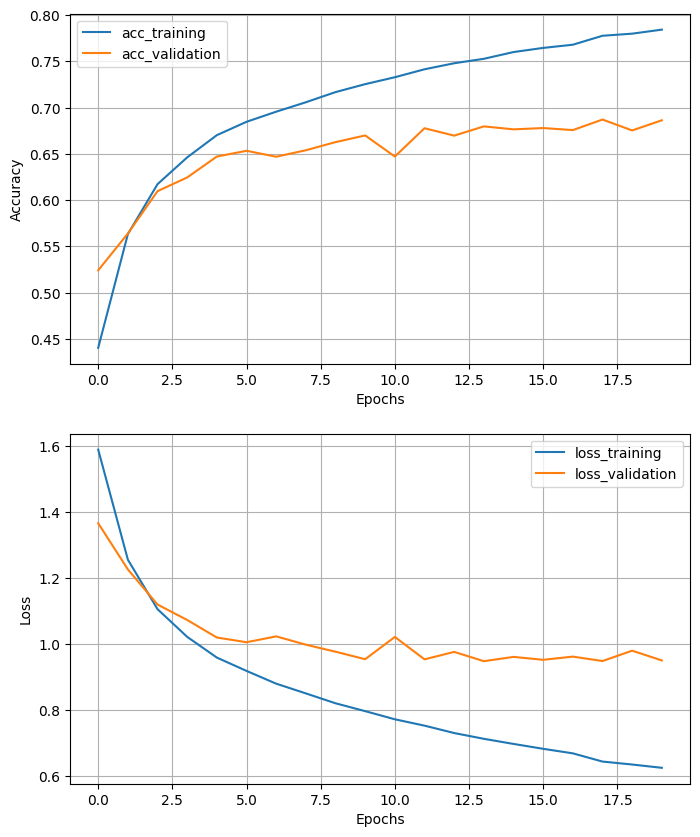

In [47]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [48]:
test(deep_model)

Test Loss: 0.93407404 ---------- Test Accuracy: 69.1900%


`%ENDCODE`

# [TO COMPLETE] Discuss your results

In the discussion, you need to clearly motivate your choice of hyperparameters, what work and what did not work.
You also need to plot all the results of experiments you have conducted.

`%STARTEXT`

The best model that I found is a model with 2 convolutional layers with the following hyperparameters:

* batch_size = 128
* conv_filters (number of filters) = [128, 64]
* kernel_sizes (filter size) = [[3, 3], [2, 2]]
* max_pool_sizes (size of pooling layers) = [[2, 2], [2, 2]]
* act_fs = [F.tanh, F.tanh]
* num_epochs = 20

The achieved accuracy in the test set is 69.19%.

Discussion:
Started from the baseline model, I have tested serveral models by changing the hyperparameters one after another (which I will discuss in the textbox below). Compared to the baseline model, the only hyperparameters which remain unchanged are `kernel_sizes`, `max_pool_sizes` and `num_epochs`. Out of the hyperparameters that have changed, `conv_filters` and `act_fs` seem to have the most influence towards test accuracy. However, by having more number of filters, the improve of accuracy comes with a cost of extra training time.

Overall, this model has accuracy of 69.19% and training time 185 seconds. Whereas the baseline model had 62.37% of test accuracy and 137 seconds of training time. The improvement in the model (in terms of test accuracy) comes with a trade off with training time.

Besides, I tested also other models:
* First model: modified conv_filters to [64, 32].
* Second model: updated batch_size to 128.
* Third model: changed activation functions to `tanh`.
* Last model: again modified conv_filters to [128, 64].

Discussion:
1. By making conv_filters larger to [64, 32], it's obvious that this model is better than the baseline as the test accuracy has improved from 62.37% to 66.38%. However, with more filters in the model, the training time has increased from 137 seconds to 157 seconds.

2. Next I wanted to try to decrease the batch size from 256 to 128. This did not help with test accuracy, however this change did decrease training time to 151 seconds.

3. Then the activation functions were changed to 'tanh', this model is preferred over the last as its test accuracy is 68.24% with an increase of training time of 156 seconds.

4. Finally, as making conv_filters larger helped with test accuracy, I wanted to check whether the test accuracy would improve again by making conv_filters even larger. This was true and we have achieved an accuracy of 69.19%. However, the training time is now significantly longer at 185 seconds.

Theoretically, increase the number of epochs would also improve the model. However, I did not consider this possibility as it would increase training time exponentially.



`%ENDTEXT`

# Transfer Learning with ResNet18 + ImageNet

Let's now experiment with transfer learning. We will now load the model structure and weights of a small [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) (which is still pretty big!), pretrained on the ImageNet dataset. We will then add a fully connected layer at the end of the network and fine-tune it on the CIFAR10 dataset. In this way, we can leverage the knowledge already present in the pre-trained weight and transfer it on our task!

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
RESNET18 = resnet18(pretrained=True)
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 1000]                --
├─Conv2d: 1-1                            [64, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 16, 16]          128
├─ReLU: 1-3                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 64, 8, 8]            --
├─Sequential: 1-5                        [64, 64, 8, 8]            --
│    └─BasicBlock: 2-1                   [64, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [64, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [64, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [64, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [64, 64, 8, 8]            --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. We will re-define it and make it map the features learned in the previous layer to the 10 classes of the CIFAR10 datset.

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [ ]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


Finally, we "freeze" the other weights in the network so that only the ones in the last layer are trainable.

In [ ]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [ ]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

Let's consider a smaller subset of CIFAR10 in order to speed-up the fine-tuning process:

In [ ]:
train_idxs = list(range(0, len(train_data), 5))  # 45000/5=9000 Tr
val_idxs = list(range(1, len(val_data), 5))  # 5000/5=1000 Val
test_idxs = list(range(1, len(test_data), 5))  # 10000/5=2000 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In order to apply custom preprocessing steps that are expected by the pretrained model, we will define a small wrapper around the CIFAR10 dataset.

In [ ]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [ ]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [ ]:
num_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training,
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 40.18%, Loss: 1.81584895 ---------------- Val_Acc: 61.50%, Val_Loss: 1.36998916
epoch: 2 -> Accuracy: 66.10%, Loss: 1.17684007 ---------------- Val_Acc: 66.10%, Val_Loss: 1.06831837
epoch: 3 -> Accuracy: 71.21%, Loss: 0.96824020 ---------------- Val_Acc: 68.60%, Val_Loss: 0.95038062
epoch: 4 -> Accuracy: 73.50%, Loss: 0.87114418 ---------------- Val_Acc: 69.30%, Val_Loss: 0.90819156
epoch: 5 -> Accuracy: 75.02%, Loss: 0.81054300 ---------------- Val_Acc: 70.70%, Val_Loss: 0.84594512
epoch: 6 -> Accuracy: 75.42%, Loss: 0.76418740 ---------------- Val_Acc: 71.20%, Val_Loss: 0.81875068
epoch: 7 -> Accuracy: 76.31%, Loss: 0.73447031 ---------------- Val_Acc: 72.30%, Val_Loss: 0.79542124
epoch: 8 -> Accuracy: 76.77%, Loss: 0.71161973 ---------------- Val_Acc: 71.50%, Val_Loss: 0.78861505
epoch: 9 -> Accuracy: 77.14%, Loss: 0.70272279 ---------------- Val_Acc: 72.80%, Val_Loss: 0.76256943
epoch: 10 -> Accuracy: 78.00%, Loss: 0.67505950 ---------------- Val_Acc: 72.90%, 

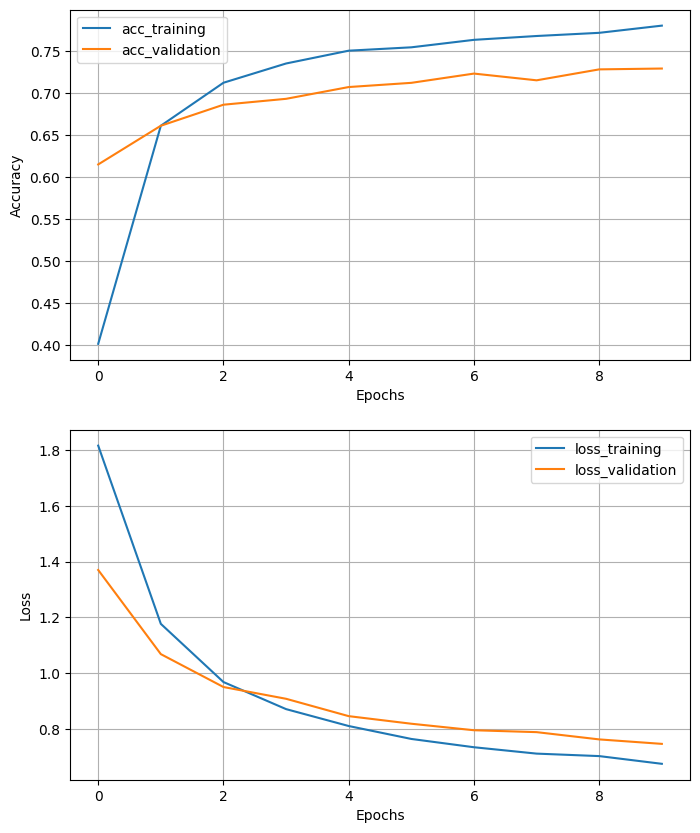

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 0.74855757 ---------- Test Accuracy: 74.6500%


Notice how we got this result by leveraging a model freely available on the internet and trained on another dataset. That's the power of transfer learning!